Run cells one by one, enter huggingface token when asked.


Account should be able to freely access: https://huggingface.co/CompVis/stable-diffusion-v1-4

In [1]:
!pip install diffusers transformers gradio scipy ftfy "ipywidgets>=7,<8"

In [2]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-e1rpyyel
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-e1rpyyel
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
  import torch
  import numpy as np
  import cv2
  import PIL
  from segment_anything import SamPredictor, sam_model_registry
  from PIL import Image
  import matplotlib.pyplot as plt
  import gradio as gr

  # Download SAM model checkpoint (can also upload to colab if you have it)
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

  # Load SAM
  sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
  sam.to("cuda")
  predictor = SamPredictor(sam)


--2025-06-27 05:36:02--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.10, 13.227.219.70, 13.227.219.59, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth.1’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   133MB/s    in 2.7s    

2025-06-27 05:36:04 (133 MB/s) - ‘sam_vit_b_01ec64.pth.1’ saved [375042383/375042383]



In [4]:
def generate_sam_mask(input_image, input_point):
    image_np = np.array(input_image)
    predictor.set_image(image_np)

    input_point = np.array([input_point])
    input_label = np.array([1])

    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )

    return Image.fromarray((masks[0] * 255).astype(np.uint8))  # single-channel mask

In [5]:
from diffusers import  StableDiffusionXLInpaintPipeline
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load SDXL inpainting pipeline
pipe = StableDiffusionXLInpaintPipeline.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    variant="fp16" if device == "cuda" else None,
    use_safetensors=True,
).to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [6]:
# Load image
image = Image.open("test6.jpg").convert("RGB")
image_np = np.array(image)
predictor.set_image(image_np)

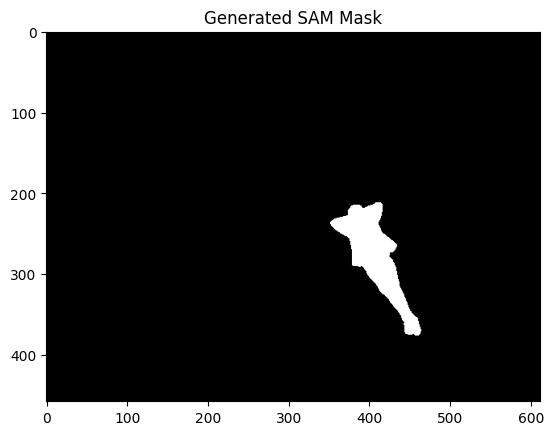

In [7]:
# Step 2: Generate mask using SAM
from PIL import Image, ImageOps
bbox_coords = [300, 200, 500, 400]  # Replace with your values manually

input_box = np.array([bbox_coords])
masks, scores, _ = predictor.predict(box=input_box, multimask_output=True)

# Pick best mask (highest score)
mask = masks[np.argmax(scores)]
mask_image = Image.fromarray((mask * 255).astype(np.uint8))

# # Show the selected mask
plt.imshow(mask_image, cmap='gray')
plt.title("Generated SAM Mask")
plt.show()


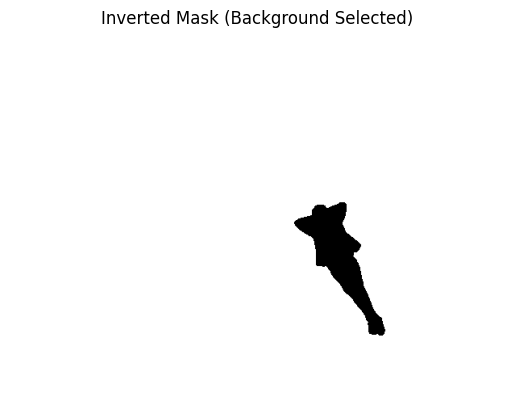

In [8]:
background_mask_image = ImageOps.invert(mask_image)

# Show the background mask
plt.imshow(background_mask_image, cmap='gray')
plt.title("Inverted Mask (Background Selected)")
plt.axis("off")
plt.show()

In [ ]:
#Replace Foreground object
num_variants = 3
images = []

for i in range(num_variants):
    generator = torch.Generator(device="cuda").manual_seed(i)  # different seed per run

    result = pipe(
        prompt = "a realistic horse lying on the grass under sunlight, relaxing, photorealistic, natural lighting",
        negative_prompt = "blurry, distorted, painting, cartoon, person, human, watermark",
        image=image.convert("RGB").resize((1024, 1024)),
        mask_image=mask_image.convert("L").resize((1024, 1024)),
        generator=generator
    ).images[0]

    images.append(result)


plt.figure(figsize=(9, 3))
plt.subplot(1, num_variants + 1, 1); plt.imshow(image); plt.title("Input")

for i in range(num_variants):
    plt.subplot(1, num_variants + 1, i + 2)
    plt.imshow(images[i])
    plt.title(f"Variant {i+1}")

plt.tight_layout()
plt.show()


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

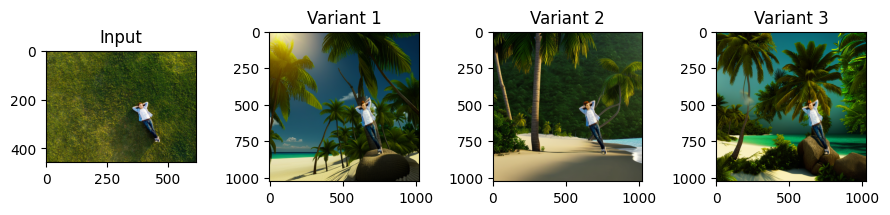

In [36]:
#Replace Background
num_variants = 3
images = []

for i in range(num_variants):
    generator = torch.Generator(device="cuda").manual_seed(i)  # different seed per run

    result = pipe(
        prompt = "a beautiful photorealistic sandy beach with white sand as seen from top view, natural lighting",
        negative_prompt = "blurry, distorted, painting, person, animal, cartoon, watermark",
        image=image.convert("RGB").resize((1024, 1024)),
        mask_image=background_mask_image.convert("L").resize((1024, 1024)),
        generator=generator
    ).images[0]

    images.append(result)


plt.figure(figsize=(9, 3))
plt.subplot(1, num_variants + 1, 1); plt.imshow(image); plt.title("Input")

for i in range(num_variants):
    plt.subplot(1, num_variants + 1, i + 2)
    plt.imshow(images[i])
    plt.title(f"Variant {i+1}")

plt.tight_layout()
plt.show()


In [ ]:
# Function to handle crop and inpainting
from PIL import ImageDraw
def inpaint_with_crop(cropped_region):
    # cropped_region is a tuple: (image, (x0, y0, x1, y1))
    img_pil, bbox = cropped_region
    x0, y0, x1, y1 = map(int, bbox)

    # Create mask image from bbox
    mask_image = Image.new("L", img_pil.size, 0)
    draw = ImageDraw.Draw(mask_image)
    draw.rectangle([x0, y0, x1, y1], fill=255)

    # Show mask for verification
    plt.imshow(mask_image, cmap='gray')
    plt.title("Generated Mask")
    plt.axis("off")
    plt.show()

    # Run SDXL inpainting
    num_variants = 3
    images = []

    prompt = "a clean grassy field with no people or animals, seamless, photorealistic, natural lighting, undisturbed, untouched"
    negative_prompt = "person, animal, object, blurry, distorted, painting, cartoon, watermark"

    for i in range(num_variants):
        generator = torch.Generator(device="cuda").manual_seed(i)
        result = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            image=img_pil,
            mask_image=mask_image,
            generator=generator,
            guidance_scale=7.5
        ).images[0]
        images.append(result)

    return images


In [ ]:
# Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("### Select region to remove and inpaint with SDXL")
    with gr.Row():
        input_image = gr.Image(value=image, type="pil", tool="select", label="Select region to remove")
    outputs = [gr.Image(label=f"Variant {i+1}") for i in range(3)]
    submit_btn = gr.Button("Remove Object")
    submit_btn.click(fn=inpaint_with_crop, inputs=input_image, outputs=outputs)

# Launch
demo.launch()